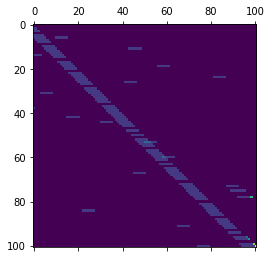

In [135]:
### importing modules and simulator class
%matplotlib inline
import autograd as ag
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import random
from numpy.random import choice

class Simulator:

    """ Base class for simulators with access to joint score and joint likelihood ratios. """

    def __init__(self):
        pass

    def get_discretization(self):
        raise NotImplementedError

    def theta_defaults(self, n_thetas=100, single_theta=False, random=True):
        raise NotImplementedError()

    def rvs(self, theta, n, random_state=None):
        raise NotImplementedError()

    def rvs_score(self, theta, theta_score, n, random_state=None):
        raise NotImplementedError()

    def rvs_ratio(self, theta, theta0, theta1, n, random_state=None):
        raise NotImplementedError()

    def rvs_ratio_score(self, theta, theta0, theta1, theta_score, n, random_state=None):
        raise NotImplementedError()
        
def cl_markov_matrix(max_roll=6, jump_at_end=True):
    # Create the basic transition matrix:
    mat = np.zeros((101, 101))
    for i in range(101):
        mat[i + 1:i + 1 + max_roll, i] = 1. / max_roll
        
    # We could alternatively use scipy.linalg.circulent as follows:
    # mat = circulant([0, *np.ones(max_rolls) / 6, *np.zeros(100)])[:101, :101]

    # rolls off the end of the board don't change the state;
    # add these probabilities to the diagonal
    mat[range(101), range(101)] += 1 - mat.sum(0)

    # account for the presence of chutes and ladders
    # we'll do this via  another transition matrix
    cl_mat = np.zeros((101, 101))
    ind = [CHUTES_LADDERS.get(i, i) for i in range(101)]
    cl_mat[ind, range(101)] = 1
    if jump_at_end:
        return cl_mat @ mat
    else:
        return mat @ cl_mat

mat = cl_markov_matrix()
plt.matshow(mat)

plt.grid(False)

In [115]:
weights = [1/6,1/6,1/6,1/6,1/6,1/6] #theta parameter



CHUTES_LADDERS = {1:38, 4:14, 9:31, 16:6, 21:42, 28:84, 36:44,
                  47:26, 49:11, 51:67, 56:53, 62:19, 64:60,
                  71:91, 80:100, 87:24, 93:73, 95:75, 98:78} #dictionary of chutes and ladders



class Chutes_Ladders(Simulator):
    n=1
    ### initialization                    
    def __init__(self, weights=weights, n=n):
        self.weights = weights
         

    
    
    
    ### creates samples x given theta (weights); p(x|theta)
    def rvs(self, n=n, theta=weights, random_state=None): 
        turns_list = [] #number of turns per game
        winner = [] #which player wins each game
        rolls_list = []
        prob_rolls = []
        
        position1_list = [] #player 1 position list
        position2_list = [] #player 2 position list
        final_position = []
        
        counter = 0
        
        
        while counter < n:
            ### setting up game
            prob = {1:theta[0], 2:theta[1], 3:theta[2],4:theta[3],5:theta[4],6:theta[5]}
            
            roll_array = np.array([1.0])
            roll_list = []
            position = []
            position1 = 0
            position2 = 0
            turns = 0
            counter += 1
            while position1 < 100 and position2 < 100:
                turns += 1
                ### player_1's turn
                roll1 = int(choice([1,2,3,4,5,6], size = 1, replace=True, p=theta))
                position1 += roll1
                position1 = CHUTES_LADDERS.get(position1, position1)
                
                ### player_2's turn
                roll2 = int(choice([1,2,3,4,5,6], size = 1, replace=True, p=theta))#roll_weighted()
                position2 += roll2
                position2 = CHUTES_LADDERS.get(position2, position2)
                
                ### logging positions/roll data
                position1_list += [position1]
                position2_list += [position2]
                position += [[position1, position2]]
                roll_list += [[roll1, roll2]]
                p_rolls = prob[roll1] * prob[roll2]
                roll_array *= p_rolls
                
                
                ### ends game
                if position1 >= 100:
                    final_position += [position]
                    winner += [1]
                    turns_list += [turns]
                    rolls_list += [roll_list]
                    prob_rolls += list(np.log(roll_array))
                    
                    position1_list += ["Player 1 Wins"]
                    position2_list += ["Player 1 Wins"]
                    continue
                elif position2 >= 100:
                    final_position += [position]
                    rolls_list += [roll_list]
                    winner += [0] 
                    turns_list += [turns]     
                    prob_rolls += list(np.log(roll_array))                    

                    position1_list += ["Player 2 Wins"]
                    position2_list += ["Player 2 Wins"]
                    continue
        return(winner, rolls_list, prob_rolls, turns_list, final_position)

        
    
    def rvs_score(self, theta, theta_score, n=n, random_state=None):
        rng = check_random_state(random_state)

        all_x = []
        all_t_xz = []
    
    
    
    
    
    def rvs_ratio(self, theta0, theta1, theta=weights, n=n, random_state=None):
        turns_list = [] #number of turns per game
        winner = [] #which player wins each game
        rolls_list = []
        prob_rolls = []
        all_log_r_xz = []
        all_r_xz = []
        
        position1_list = [] #player 1 position list
        position2_list = [] #player 2 position list
        final_position = []
        
        counter = 0
        
        
        while counter < n:
            ### setting up game
            prob0 = {1:theta0[0], 2:theta0[1], 3:theta0[2],4:theta0[3],5:theta0[4],6:theta0[5]}
            prob1 = {1:theta1[0], 2:theta1[1], 3:theta1[2],4:theta1[3],5:theta1[4],6:theta1[5]}

            roll0_array = np.array([1.0])
            roll1_array = np.array([1.0])
            roll_list = []
            position = []
            log_p_xz_theta0 = []
            log_p_xz_theta1 = []
            
            position1 = 0
            position2 = 0
            turns = 0
            counter += 1
            
            
            while position1 < 100 and position2 < 100:
                turns += 1
                ### player_1's turn
                roll1 = int(choice([1,2,3,4,5,6], size = 1, replace=True, p=theta))
                position1 += roll1
                position1 = CHUTES_LADDERS.get(position1, position1)
                
                ### player_2's turn
                roll2 = int(choice([1,2,3,4,5,6], size = 1, replace=True, p=theta))#roll_weighted()
                position2 += roll2
                position2 = CHUTES_LADDERS.get(position2, position2)
                
                ### logging positions/roll data
                position1_list += [position1]
                position2_list += [position2]
                position += [[position1, position2]]
                roll_list += [[roll1, roll2]]
                p0_rolls = prob0[roll1] * prob0[roll2]
                p1_rolls = prob1[roll1] * prob1[roll2]

                roll0_array *= p0_rolls
                roll1_array *= p1_rolls
                
                
                ### ends game
                if position1 >= 100:
                    final_position += [position]
                    winner += [1]
                    turns_list += [turns]
                    rolls_list += [roll_list]
                    all_log_r_xz += list(np.log(roll0_array) - np.log(roll1_array))    
                    all_r_xz += list(np.exp(np.log(roll0_array) - np.log(roll1_array)))
                    
                    position1_list += ["Player 1 Wins"]
                    position2_list += ["Player 1 Wins"]
                    continue
                elif position2 >= 100:
                    final_position += [position]
                    rolls_list += [roll_list]
                    winner += [0] 
                    turns_list += [turns]     
                    all_log_r_xz += list(np.log(roll0_array) - np.log(roll1_array))
                    all_r_xz += list(np.exp(np.log(roll0_array) - np.log(roll1_array)))
                    
                    position1_list += ["Player 2 Wins"]
                    position2_list += ["Player 2 Wins"]
                    continue
        
        
        return(winner, all_r_xz)
        






#     def rvs_ratio_score(self, theta, theta0, theta1, theta_score, n, random_state=None):
#         raise NotImplementedError()
        

    
test = Chutes_Ladders()



In [116]:
winner,rolls,log_p_xz, turns, position = test.rvs(theta=[.1,.1,.1,.1,.1,.5],n=3)
print(winner, rolls, log_p_xz, turns, position, sep="\n\n")

[0, 0, 1]

[[[6, 3], [6, 6], [1, 6], [6, 3], [2, 6], [1, 6], [4, 6], [3, 1], [6, 6], [5, 6], [4, 6], [6, 6]], [[6, 6], [1, 6], [6, 2], [2, 4], [3, 6], [6, 5], [6, 6], [1, 6], [6, 1], [6, 6], [5, 6], [6, 6], [6, 5], [6, 6], [1, 3], [6, 6]], [[6, 2], [6, 5], [1, 6], [4, 6], [6, 6], [6, 1], [6, 6], [3, 5], [3, 6], [3, 4], [6, 3], [6, 1], [4, 6], [4, 6], [6, 2], [6, 6], [6, 6], [6, 6], [6, 6], [2, 1], [3, 6], [4, 6]]]

[-32.729911457779693, -41.493964727127455, -61.077796280885501]

[12, 16, 22]

[[[6, 3], [12, 31], [13, 37], [19, 40], [42, 46], [43, 52], [26, 58], [29, 59], [35, 65], [40, 91], [44, 97], [50, 103]], [[6, 6], [7, 12], [13, 14], [15, 18], [18, 24], [24, 29], [30, 35], [31, 41], [37, 42], [43, 48], [48, 54], [54, 60], [60, 65], [66, 91], [67, 94], [73, 100]], [[6, 2], [12, 7], [13, 13], [17, 19], [23, 25], [29, 26], [35, 32], [38, 37], [41, 43], [44, 26], [50, 29], [53, 30], [57, 44], [61, 50], [67, 52], [73, 58], [79, 60], [85, 66], [91, 72], [73, 73], [76, 79], [100, 85]]]


In [87]:
game1 = [x for i in rolls[0] for x in i]
game2 = [x for i in rolls[1] for x in i]
game3 = [x for i in rolls[2] for x in i]
print(game3.count(6))
print(len(game3) - game3.count(6))

12
16


Even weighted die: 
P(Player 1 wins) = .5077
P(Player 2 wins) = .4923

In [117]:
ag.grad_and_aux(log_p_xz, winner)

<function autograd.differential_operators.grad_and_aux.<locals>.grad_and_aux_fun>